In [14]:
import os
import pyspark
from pyspark.sql import *

try:
    sc = pyspark.SparkContext('local[*]',environment = {})
except:
    sc = sc

os.system('wget http://files.grouplens.org/datasets/movielens/ml-1m.zip; unzip ml-1m.zip')

0

### 1. Frequent Itemsets and FP-Growth algorithm 
#### Task: 4

In [15]:
from pyspark.mllib.fpm import FPGrowth

# Read movie names from "movies.dat" file
lines = sc.textFile("ml-1m/movies.dat")
movienames = lines.map(lambda l: l.split("::")). \
    map(lambda p: (int(p[0]), p[1])).collect()
# Convert to dictionary for printing lookup
movienames = dict(movienames)

# Read ratings file as lines of text
lines = sc.textFile("ml-1m/ratings.dat")
# Group user ratings into (user, list of rated movie ids)
usermovies = lines.map(lambda l: l.split("::")). \
    map(lambda p: (int(p[0]), int(p[1]))).groupByKey()
# Take only the list part
usermovies = usermovies.map(lambda p: list(p[1]))
usercount = usermovies.count()

# Set the minimum support threshold
min_support_threshold = 0.3

# Run FP-Growth algorithm
model = FPGrowth.train(usermovies, minSupport=min_support_threshold, numPartitions=10)
result = model.freqItemsets()

# Print combinations of movies with at least 30% support
for x in result.collect():
    keys = x[0]
    if len(keys) > 1:
        fpairs = []
        for y in keys:
            fpairs.append(movienames[y])
        percentage = (x[1] / usercount) * 100
        if percentage >= 30:
            print(fpairs)
            print("Seen by " + str(round(percentage, 2)) + "% of movie raters\n")

['Men in Black (1997)', 'Jurassic Park (1993)']
Seen by 32.1% of movie raters

['Men in Black (1997)', 'Terminator 2: Judgment Day (1991)']
Seen by 30.71% of movie raters

['Raiders of the Lost Ark (1981)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']
Seen by 33.1% of movie raters

['Raiders of the Lost Ark (1981)', 'Star Wars: Episode IV - A New Hope (1977)']
Seen by 32.65% of movie raters

['Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)']
Seen by 38.99% of movie raters

['Star Wars: Episode V - The Empire Strikes Back (1980)', 'American Beauty (1999)']
Seen by 30.28% of movie raters

['Being John Malkovich (1999)', 'American Beauty (1999)']
Seen by 31.19% of movie raters

['Fargo (1996)', 'American Beauty (1999)']
Seen by 30.73% of movie raters

['Star Wars: Episode VI - Return of the Jedi (1983)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']
Seen by 36.89% of movie raters

['Star Wars: Episode VI - Return o

### 2. Text document similarity search

#### TASK: 1

[('bank.txt', ['abanki', 'bankis', 'ankisa', 'nkisaf', 'kisafi', 'isafin', 'safina', 'afinan', 'financ', 'inanci', 'nancia', 'ancial', 'nciali', 'cialin', 'ialint', 'alinte', 'linter', 'interm', 'nterme', 'termed', 'ermedi', 'rmedia', 'mediar', 'ediary', 'diarya', 'iaryan', 'aryand', 'ryandm', 'yandmo', 'andmon', 'ndmone', 'dmoney', 'moneyc', 'oneycr', 'neycre', 'eycrea', 'ycreat', 'creato', 'reator', 'eatort', 'atorth', 'tortha', 'orthat', 'rthatc', 'thatcr', 'hatcre', 'atcrea', 'tcreat', 'create', 'reates', 'eatesm', 'atesmo', 'tesmon', 'esmone', 'smoney', 'moneyb', 'oneyby', 'neybyl', 'eybyle', 'ybylen', 'bylend', 'ylendi', 'lendin', 'ending', 'ndingm', 'dingmo', 'ingmon', 'ngmone', 'gmoney', 'moneyt', 'oneyto', 'neytoa', 'eytoab', 'ytoabo', 'toabor', 'oaborr', 'aborro', 'borrow', 'orrowe', 'rrower', 'rowert', 'owerth', 'werthe', 'erther', 'rthere', 'thereb', 'hereby', 'erebyc', 'rebycr', 'ebycre', 'bycrea', 'ycreat', 'creati', 'reatin', 'eating', 'atinga', 'tingac', 'ingaco', 'ngac

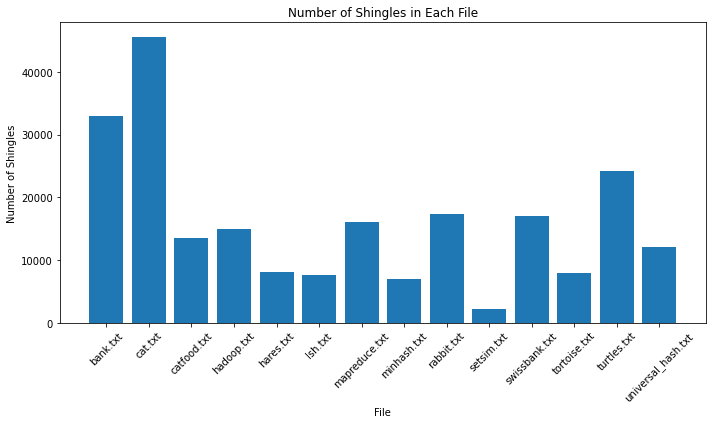

In [16]:
import pyspark
import re
import matplotlib.pyplot as plt

try:
    sc = pyspark.SparkContext('local[*]', environment={})
except:
    sc = sc

def make_shingles(text, shingle_len):
    text = text.lower()
    text = re.sub(r'[^a-z]+', '', text)
    for i in range(0, len(text) - shingle_len - 1):
        yield text[i:i+shingle_len]

shingle_length = 6

files = sc.wholeTextFiles('*.txt')
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length))))
res = files.collect()
print(files.take(1))

# Extract file names and shingles separately
file_names, shingles = zip(*res)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(file_names, [len(s) for s in shingles])
plt.xlabel('File')
plt.ylabel('Number of Shingles')
plt.title('Number of Shingles in Each File')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('shingles_output.png')

### TASK: 2

In [17]:
import pyspark
import re

try:
    sc = pyspark.SparkContext('local[*]',environment = {})
except:
    sc = sc

def make_shingles(text, shingle_len):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z\s]+', '', text)
    for i in range(0, len(text) - shingle_len + 1):
        yield text[i:i+shingle_len]
 

shingle_length = 6        
        
files = sc.wholeTextFiles('*.txt')
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1] ,shingle_length) ) ) )
res = files.collect()
print(files.take(1))

[('bank.txt', ['a bank', ' bank ', 'bank i', 'ank is', 'nk is ', 'k is a', ' is a ', 'is a f', 's a fi', ' a fin', 'a fina', ' finan', 'financ', 'inanci', 'nancia', 'ancial', 'ncial ', 'cial i', 'ial in', 'al int', 'l inte', ' inter', 'interm', 'nterme', 'termed', 'ermedi', 'rmedia', 'mediar', 'ediary', 'diary ', 'iary a', 'ary an', 'ry and', 'y and ', ' and m', 'and mo', 'nd mon', 'd mone', ' money', 'money ', 'oney c', 'ney cr', 'ey cre', 'y crea', ' creat', 'creato', 'reator', 'eator ', 'ator t', 'tor th', 'or tha', 'r that', ' that ', 'that c', 'hat cr', 'at cre', 't crea', ' creat', 'create', 'reates', 'eates ', 'ates m', 'tes mo', 'es mon', 's mone', ' money', 'money ', 'oney b', 'ney by', 'ey by ', 'y by l', ' by le', 'by len', 'y lend', ' lendi', 'lendin', 'ending', 'nding ', 'ding m', 'ing mo', 'ng mon', 'g mone', ' money', 'money ', 'oney t', 'ney to', 'ey to ', 'y to a', ' to a ', 'to a b', 'o a bo', ' a bor', 'a borr', ' borro', 'borrow', 'orrowe', 'rrower', 'rower ', 'ower

#### TASK: 4

In [18]:
import pyspark
import re
import random
import numpy as np

from numpy import uint32, uint64

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def make_shingles(text, shingle_len, Ashingle, Pshingle):
    out = []
    for i in range(len(text) - shingle_len + 1):
        out.append(string_hash(text[i:i+shingle_len], shingle_len, Ashingle, Pshingle))
    return out

def uint32_hash(stringhashes, A):
    for i in range(0, len(stringhashes)):
        stringhashes[i] = uint32((uint64(A) * uint64(stringhashes[i])) >> uint64(32))
    return stringhashes

def min_hash(hashes, minhash_A):
    minhashes = []
    for i in range(0, len(minhash_A)):
        minhashes.append(min(uint32_hash(hashes, minhash_A[i])))
    return minhashes

# Initialize SparkContext
try:
    sc = pyspark.SparkContext('local[*]', environment={})
except:
    sc = sc

shingle_length = 6

files = sc.wholeTextFiles('*.txt')

# Randomly generate hash parameters
Ashingle, Pshingle = generate_random_hash_params_A_P()

# Generate shingles with hash codes
files = files.map(lambda p: (p[0].split("/")[-1], make_shingles(p[1], shingle_length, Ashingle, Pshingle)))

# Define the number of MinHashes
num_minhashes = 15

# Calculate MinHashes
minhash_A = [random.getrandbits(64) for _ in range(0, num_minhashes)]
minhashes = files.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
minhashes.cache()
res = minhashes.collect()

# Jaccard similarity estimation
for x in res:
    jaccrow = minhashes.map(lambda p: (p[0], sum(np.array(p[1]) - np.array(x[1]) == 0) / num_minhashes)).collect()
    for y in jaccrow:
        print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(y[1] * 100) + " %")

bank.txt             vs. bank.txt             similarity: 100.0 %
bank.txt             vs. cat.txt              similarity: 0.0 %
bank.txt             vs. catfood.txt          similarity: 6.666666666666667 %
bank.txt             vs. hadoop.txt           similarity: 6.666666666666667 %
bank.txt             vs. hares.txt            similarity: 0.0 %
bank.txt             vs. lsh.txt              similarity: 0.0 %
bank.txt             vs. mapreduce.txt        similarity: 0.0 %
bank.txt             vs. minhash.txt          similarity: 0.0 %
bank.txt             vs. rabbit.txt           similarity: 0.0 %
bank.txt             vs. setsim.txt           similarity: 6.666666666666667 %
bank.txt             vs. swissbank.txt        similarity: 0.0 %
bank.txt             vs. tortoise.txt         similarity: 6.666666666666667 %
bank.txt             vs. turtles.txt          similarity: 13.333333333333334 %
bank.txt             vs. universal_hash.txt   similarity: 6.666666666666667 %
cat.txt          

#### TASK: 5

In [19]:
import pyspark
import re
import random
import numpy as np

from numpy import uint32, uint64

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def uint32_hash(stringhashes, A):
    for i in range(0, len(stringhashes)):
        stringhashes[i] = uint32((uint64(A) * uint64(stringhashes[i])) >> uint64(32))
    return stringhashes

def min_hash(hashes, minhash_A):
    minhashes = []
    for i in range(0, len(minhash_A)):
        minhashes.append(min(uint32_hash(hashes, minhash_A[i])))
    return minhashes

# Initialize SparkContext
try:
    sc = pyspark.SparkContext('local[*]', environment={})
except:
    sc = sc

shingle_length = 6

files = sc.wholeTextFiles('*.txt')

# Randomly generate hash parameters
Ashingle, Pshingle = generate_random_hash_params_A_P()

# Generate shingles with hash codes
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length, Ashingle, Pshingle))))

# Define the desired error rate
error_rate = 0.05

# Calculate the number of MinHashes needed
num_minhashes = int((1 / error_rate) ** 2)

# Calculate MinHashes
minhash_A = [random.getrandbits(64) for _ in range(0, num_minhashes)]
minhashes = files.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
minhashes.cache()
res = minhashes.collect()

# Jaccard similarity estimation
for x in res:
    jaccrow = minhashes.map(lambda p: (p[0], sum(np.array(p[1]) - np.array(x[1]) == 0) / num_minhashes)).collect()
    for y in jaccrow:
        print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(y[1] * 100) + " %")

bank.txt             vs. bank.txt             similarity: 100.0 %
bank.txt             vs. cat.txt              similarity: 12.5 %
bank.txt             vs. catfood.txt          similarity: 12.0 %
bank.txt             vs. hadoop.txt           similarity: 11.0 %
bank.txt             vs. hares.txt            similarity: 11.25 %
bank.txt             vs. lsh.txt              similarity: 4.75 %
bank.txt             vs. mapreduce.txt        similarity: 11.0 %
bank.txt             vs. minhash.txt          similarity: 6.75 %
bank.txt             vs. rabbit.txt           similarity: 10.5 %
bank.txt             vs. setsim.txt           similarity: 3.25 %
bank.txt             vs. swissbank.txt        similarity: 15.0 %
bank.txt             vs. tortoise.txt         similarity: 8.0 %
bank.txt             vs. turtles.txt          similarity: 14.499999999999998 %
bank.txt             vs. universal_hash.txt   similarity: 6.5 %
cat.txt              vs. bank.txt             similarity: 12.5 %
cat.txt    

#### TASK: 6

In [20]:
import pyspark
import re
import random
import numpy as np

from numpy import uint32, uint64

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def make_shingles(text, shingle_len, Ashingle, Pshingle):
    out = []
    for i in range(len(text) - shingle_len + 1):
        out.append(string_hash(text[i:i+shingle_len], shingle_len, Ashingle, Pshingle))
    return out

def uint32_hash(stringhashes, A):
    for i in range(0, len(stringhashes)):
        stringhashes[i] = uint32((uint64(A) * uint64(stringhashes[i])) >> uint64(32))
    return stringhashes

def min_hash(hashes, minhash_A):
    minhashes = []
    for i in range(0, len(minhash_A)):
        minhashes.append(min(uint32_hash(hashes, minhash_A[i])))
    return minhashes

# Initialize SparkContext
try:
    sc = pyspark.SparkContext('local[*]', environment={})
except:
    sc = sc

shingle_length = 6  # Adjust the shingle length here

files = sc.wholeTextFiles('*.txt')

# Randomly generate hash parameters
Ashingle, Pshingle = generate_random_hash_params_A_P()

# Generate shingles with hash codes
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length, Ashingle, Pshingle))))

# Define the desired error rate
error_rate = 0.05

# Calculate the number of MinHashes needed
num_minhashes = int((1 / error_rate) ** 2)

# Calculate MinHashes
minhash_A = [random.getrandbits(64) for _ in range(0, num_minhashes)]
minhashes = files.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
minhashes.cache()
res = minhashes.collect()

# Jaccard similarity estimation
for x in res:
    jaccrow = minhashes.map(lambda p: (p[0], sum(np.array(p[1]) - np.array(x[1]) == 0) / num_minhashes)).collect()
    for y in jaccrow:
        print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(y[1] * 100) + " %")

bank.txt             vs. bank.txt             similarity: 100.0 %
bank.txt             vs. cat.txt              similarity: 13.0 %
bank.txt             vs. catfood.txt          similarity: 11.0 %
bank.txt             vs. hadoop.txt           similarity: 12.75 %
bank.txt             vs. hares.txt            similarity: 7.5 %
bank.txt             vs. lsh.txt              similarity: 7.75 %
bank.txt             vs. mapreduce.txt        similarity: 9.75 %
bank.txt             vs. minhash.txt          similarity: 8.0 %
bank.txt             vs. rabbit.txt           similarity: 10.25 %
bank.txt             vs. setsim.txt           similarity: 3.0 %
bank.txt             vs. swissbank.txt        similarity: 11.75 %
bank.txt             vs. tortoise.txt         similarity: 5.5 %
bank.txt             vs. turtles.txt          similarity: 10.25 %
bank.txt             vs. universal_hash.txt   similarity: 8.75 %
cat.txt              vs. bank.txt             similarity: 13.0 %
cat.txt              vs.

#### TASK: 7

In [21]:
import pyspark
import re
import random
import numpy as np

from numpy import uint32, uint64

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def make_shingles(text, shingle_len, Ashingle, Pshingle):
    out = []
    for i in range(len(text) - shingle_len + 1):
        out.append(string_hash(text[i:i+shingle_len], shingle_len, Ashingle, Pshingle))
    return out

def uint32_hash(stringhashes, A):
    for i in range(0, len(stringhashes)):
        stringhashes[i] = uint32((uint64(A) * uint64(stringhashes[i])) >> uint64(32))
    return stringhashes

def min_hash(hashes, minhash_A):
    minhashes = []
    for i in range(0, len(minhash_A)):
        minhashes.append(min(uint32_hash(hashes, minhash_A[i])))
    return minhashes

# Initialize SparkContext
try:
    sc = pyspark.SparkContext('local[*]', environment={})
except:
    sc = sc

shingle_length = 6  # Adjust the shingle length here

files = sc.wholeTextFiles('*.txt')

# Randomly generate hash parameters
Ashingle, Pshingle = generate_random_hash_params_A_P()

# Generate shingles with hash codes
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length, Ashingle, Pshingle))))

# Define the desired error rate
error_rate = 0.05

# Calculate the number of MinHashes needed
num_minhashes = int((1 / error_rate) ** 2)

# Calculate MinHashes
minhash_A = [random.getrandbits(64) for _ in range(0, num_minhashes)]
minhashes = files.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
minhashes.cache()
res = minhashes.collect()

# Jaccard similarity estimation
similarity_results = []

for x in res:
    jaccrow = minhashes.map(lambda p: (p[0], sum(np.array(p[1]) - np.array(x[1]) == 0) / num_minhashes)).collect()
    similarity_results.append((x[0], jaccrow))

# Analyze similarity results
for x, jaccrow in similarity_results:
    print("Results for", x)
    matches = sorted(jaccrow, key=lambda p: p[1], reverse=True)[:2]
    for y, similarity in matches:
        if x != y:  # Ignore self-similarity comparison
            print("Match:", y, "Similarity:", similarity)

Results for bank.txt
Match: swissbank.txt Similarity: 0.1375
Results for cat.txt
Match: rabbit.txt Similarity: 0.13
Results for catfood.txt
Match: rabbit.txt Similarity: 0.12
Results for hadoop.txt
Match: mapreduce.txt Similarity: 0.13
Results for hares.txt
Match: rabbit.txt Similarity: 0.1325
Results for lsh.txt
Match: minhash.txt Similarity: 0.15
Results for mapreduce.txt
Match: hadoop.txt Similarity: 0.13
Results for minhash.txt
Match: lsh.txt Similarity: 0.15
Results for rabbit.txt
Match: turtles.txt Similarity: 0.145
Results for setsim.txt
Match: minhash.txt Similarity: 0.0725
Results for swissbank.txt
Match: bank.txt Similarity: 0.1375
Results for tortoise.txt
Match: turtles.txt Similarity: 0.105
Results for turtles.txt
Match: rabbit.txt Similarity: 0.145
Results for universal_hash.txt
Match: lsh.txt Similarity: 0.1075
